### this was initial way to do Figure 4 -  DDX and TAF peaks centeric ...

In [71]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [72]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure 4 is based on several important BED-files ...

In [74]:
feat_names = OrderedDict()
feat_names["ctcf_taf5l"] = "NT-CTCF-narrowPeak-withTAF5L-centered-CTCF"
feat_names["ctcf"] = "NT-CTCF-narrowPeak-noTAF5L-centered-CTCF"
feat_names["taf5l"] = "NT-TAF5L-narrowPeak-noCTCF-centered-TAF5L"


## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [75]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


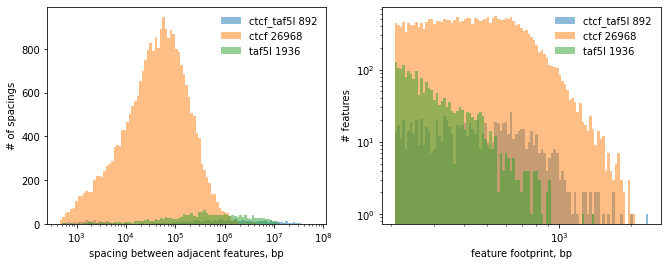

In [76]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [77]:
#let's describe our samples that we want to have in Figure 1 ...
fig4_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","taf5l_CTCF","taf5l_noCTCF","mrna_ctcf","mrna_noctcf"]

titles = fig4_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig4_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [78]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf_taf5l:(892) ...


stacking up ctcf ...
CPU times: user 174 ms, sys: 7.93 ms, total: 182 ms
Wall time: 182 ms
stacking up noctcf ...
CPU times: user 141 ms, sys: 12 ms, total: 153 ms
Wall time: 152 ms
stacking up rad21_CTCF ...
CPU times: user 170 ms, sys: 19.8 ms, total: 189 ms
Wall time: 190 ms
stacking up rad21_noCTCF ...
CPU times: user 138 ms, sys: 46 µs, total: 138 ms
Wall time: 137 ms
stacking up ins_CTCF ...
CPU times: user 129 ms, sys: 3.94 ms, total: 133 ms
Wall time: 132 ms
stacking up ins_noCTCF ...
CPU times: user 106 ms, sys: 8.08 ms, total: 114 ms
Wall time: 114 ms
stacking up G4a_r2 ...
CPU times: user 217 ms, sys: 12 ms, total: 229 ms
Wall time: 229 ms
stacking up polII ...
CPU times: user 128 ms, sys: 8.01 ms, total: 136 ms
Wall time: 136 ms
stacking up taf5l_CTCF ...
CPU times: user 190 ms, sys: 8 ms, total: 198 ms
Wall time: 197 ms
stacking up taf5l_noCTCF ...
CPU times: user 161 ms, sys: 12.1 ms, total: 173 ms
Wall time: 173 ms
stackin

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [79]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
for feature_key in stackup_dict:
    normalize_insulation_stackups_INPLACE(
        stackups_set = stackup_dict[feature_key],
        ins_keys = insulation_keys
    )

In [80]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [81]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ctcf'].shape
    center_bin = int(width/2)
    the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    # the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('ctcf_mean', "sort", 1, False)],
        idxs = np.arange( len(the_stackups['ctcf_mean']) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 892 elements of ctcf_mean into 1 groups ...
sorting 26968 elements of ctcf_mean into 1 groups ...
sorting 1936 elements of ctcf_mean into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [82]:
# # #
# # # skipping this for now ....
# # #
# CHUNK_SIZE = 100

# G4_polstall_sorted = {}
# Number_of_chunks = {}
# for feature_key in ['ctcf', 'ctcf_g4', 'g4']:
#     jjj = reordered_jdxs[feature_key]
#     features_df = dfs[feature_key]
#     # G4_polstall
#     index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
#     G4_polstall_sorted[feature_key] = []
#     Number_of_chunks[feature_key] = 0
#     _df2 = G4_polstall # works as is !!!
#     for ii in index_chunks:
#         _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#         G4_polstall_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
#         Number_of_chunks[feature_key] += 1

In [83]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "pcgene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "pcgene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig4_samples.append(feat_name)
titles = fig4_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

stacking genes up for ctcf_taf5l ...
stacking genes up for ctcf ...
stacking genes up for taf5l ...


#### plotting those running averages is integrated into `plot_stackups` function ...

In [84]:
feat_names.keys()

odict_keys(['ctcf_taf5l', 'ctcf', 'taf5l'])

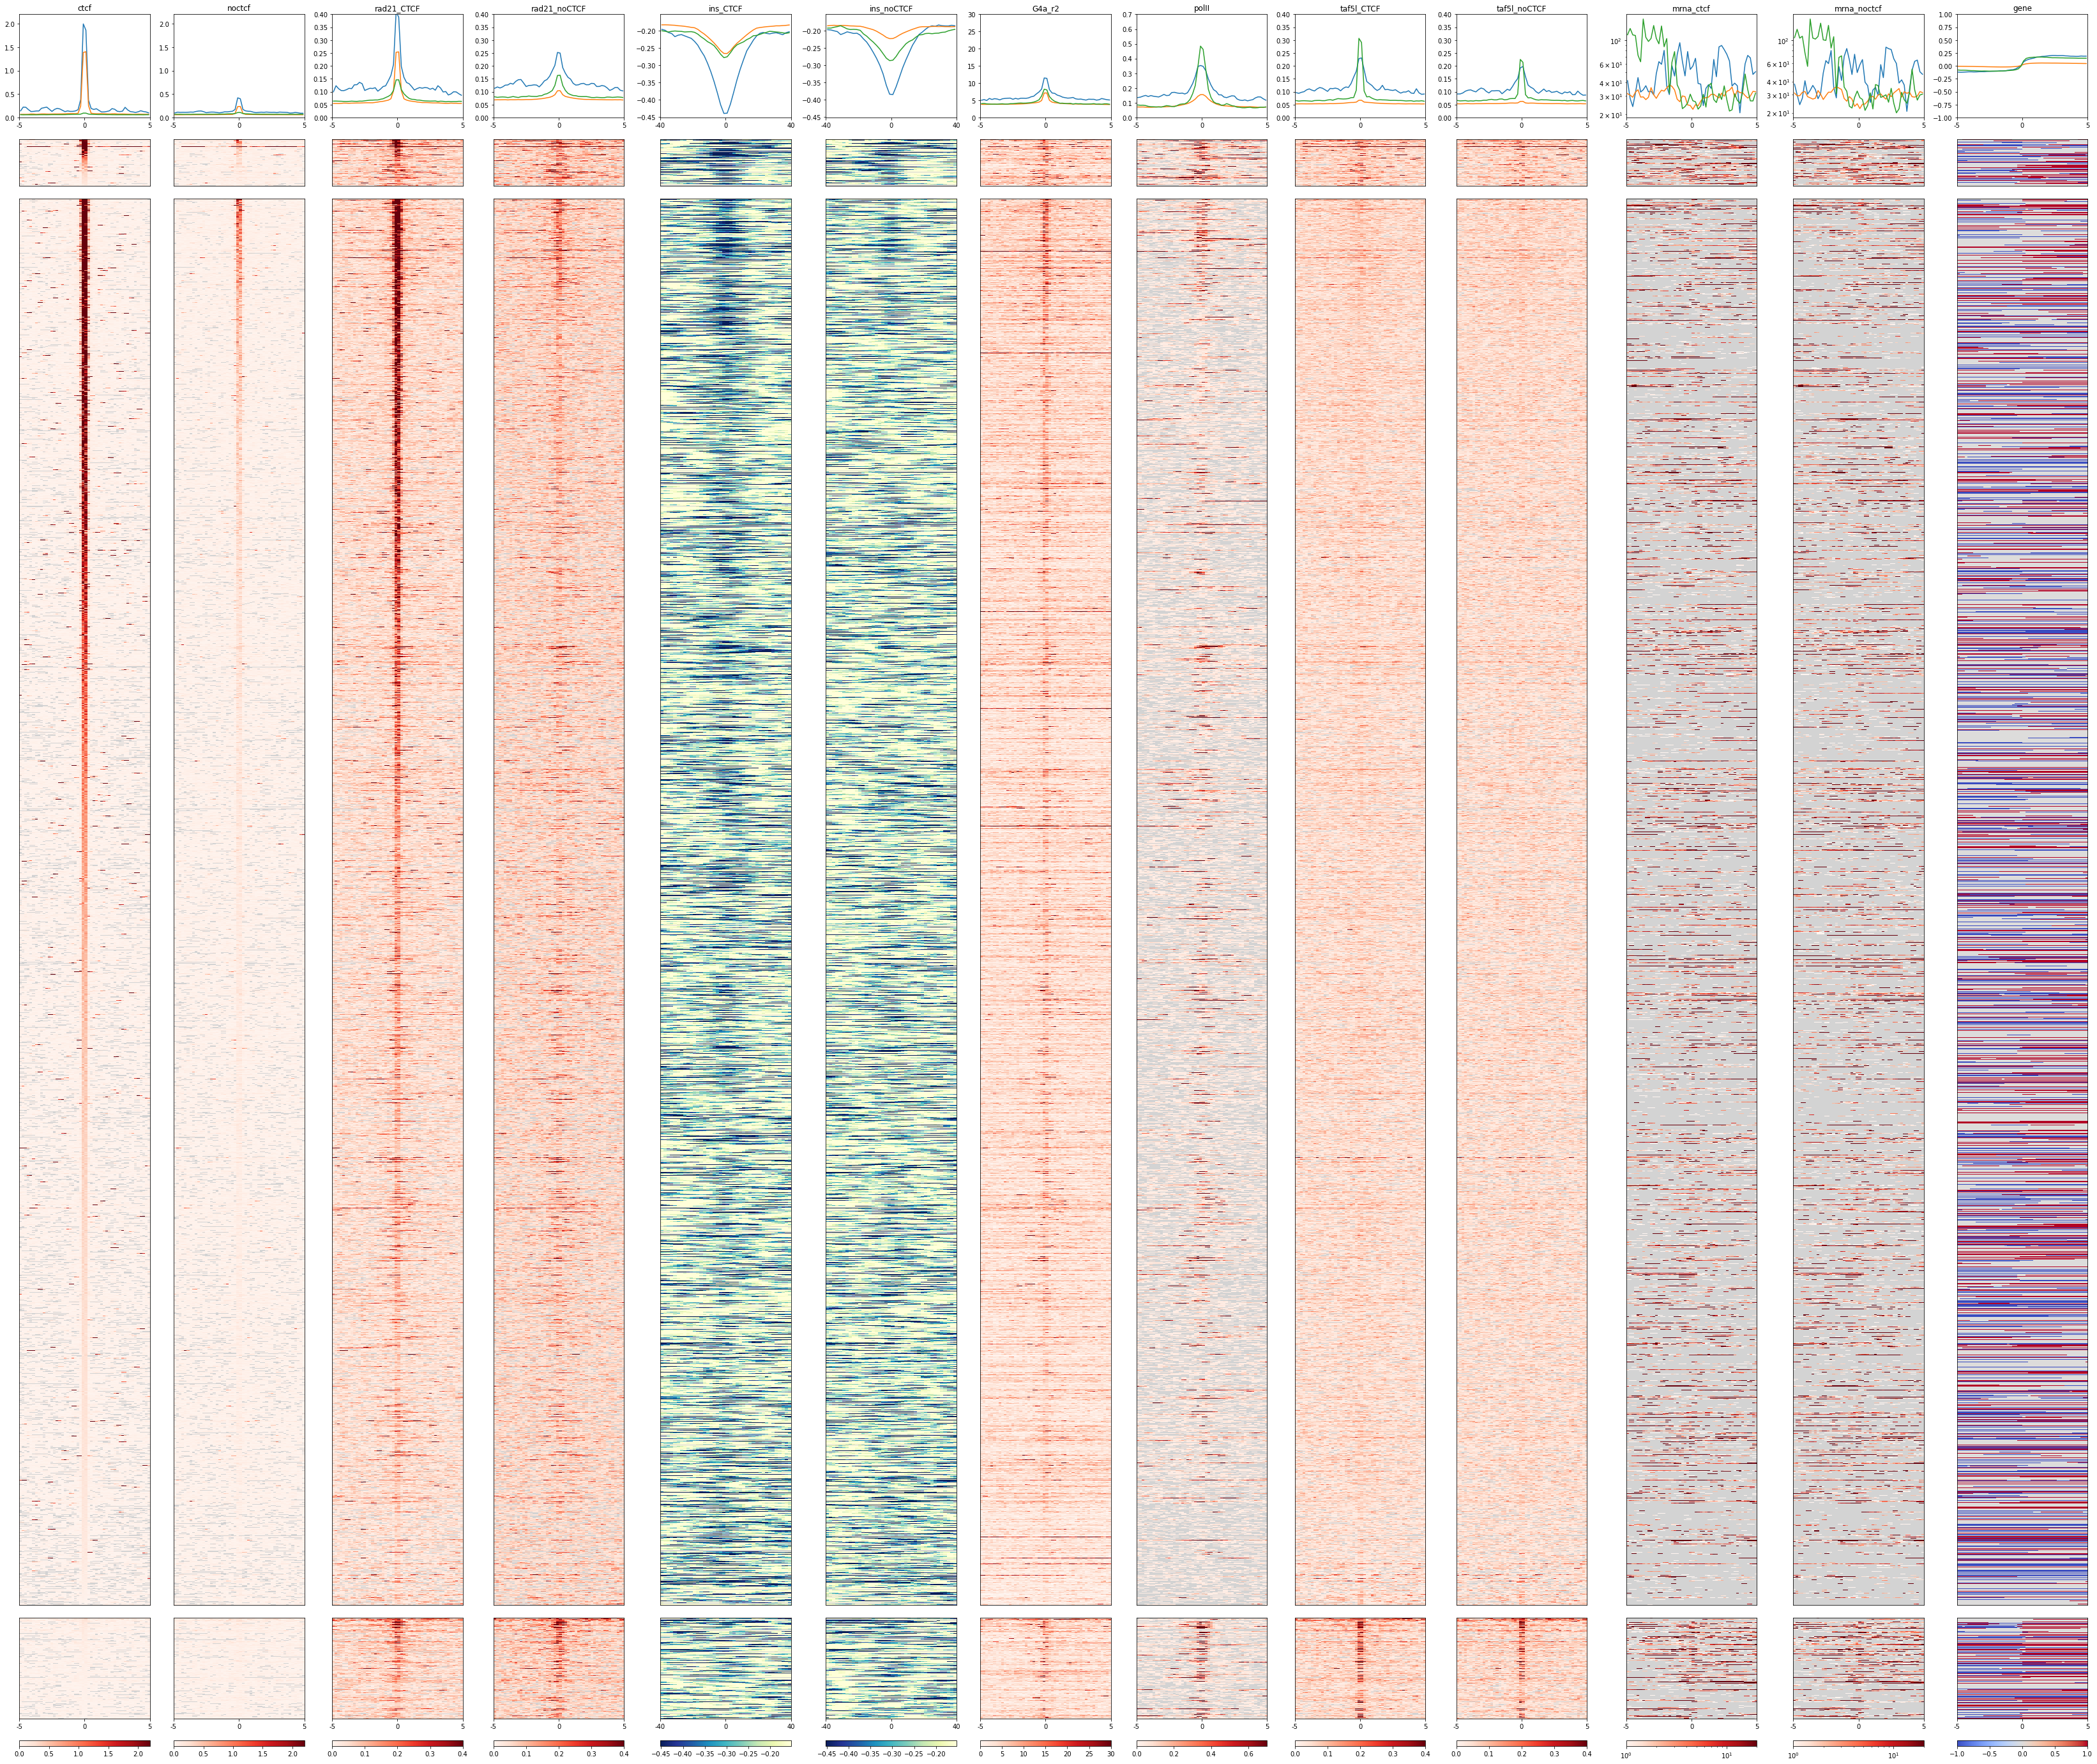

In [85]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig4_samples ]

_limss = [ limss[_k] for _k in fig4_samples ]
_cmps = [ cmps[_k] for _k in fig4_samples ]
_binsizes = [ binsizes[_k] for _k in fig4_samples ]
_norms = [ norms[_k] for _k in fig4_samples ]

# xtra_plots = [1,2]
extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

In [86]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/